In [19]:
# import trecs
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from collections import defaultdict
from chaney_utils import (
    load_sim_results,
    merge_results,
    graph_metrics,
    graph_relative_to_ideal,
)
from scipy.stats import dirichlet
DEBUG = True
id_to_readable = {
    "ideal": "ideal", 
    "target_ideal": "target ideal",
    "content_chaney": "content filtering basic",
    "content_chaney_j_1.0": "content filtering a=1.0",
    "content_chaney_j_3.0": "content filtering a=3.0",
    "content_chaney_j_0.5": "content filtering a=0.5",
    "popularity": "popularity", 
    "random": "random"
}

In [20]:
# replace with the experimental output directorie(s) from your experiment!
results = merge_results(["udps_ouput_homog_creators"])

startup_iters = 50
sim_iters = 350
timesteps = startup_iters + sim_iters

In [21]:

""" FUNCTIONS """
nA = 20 #number of atributes
width = 0.3 #for the bar plots
u = 0

target_profs = np.array(results['target_user_profiles']['ideal']) 
num_sims, num_steps, num_creators, num_attrs = target_profs.shape

actual_profs_strong_j = np.array(results['actual_user_profiles']['content_chaney_j_3.0']) 
actual_profs_normal_j = np.array(results['actual_user_profiles']['content_chaney_j_1.0'])
actual_profs_weak_j = np.array(results['actual_user_profiles']['content_chaney_j_0.5']) 

actual_profs_content = np.array(results['actual_user_profiles']['content_chaney']) 

actual_profs_ideal = np.array(results['actual_user_profiles']['ideal']) 
actual_profs_target_ideal = np.array(results['actual_user_profiles']['target_ideal']) 
actual_profs_rand = np.array(results['actual_user_profiles']['random'])
actual_profs_pop = np.array(results['actual_user_profiles']['popularity'])

def plot_profiles(blue, model, b_ts=0, orange=target_profs, o_ts=0, user=u, norm_axis=True, norm_prefs=True):
    if norm_prefs:
        plt.bar(np.arange(nA), normalize_preferences(blue[0, b_ts, user, :]), width, label="$U$ at t={}".format(b_ts))
        plt.bar(np.arange(nA) + width, normalize_preferences(orange[0, o_ts, user, :]), width, label="$U$ at t={}".format(o_ts))
    else:
        plt.bar(np.arange(nA), blue[0, b_ts, user, :], width, label="$U$ at t={}".format(b_ts))
        plt.bar(np.arange(nA) + width, orange[0, o_ts, user, :], width, label="$U$ at t={}".format(o_ts))
    
    if norm_axis:
        plt.ylim(0, 1) # to equalize the y axes
    plt.xticks(np.arange(nA) + width/2, np.arange(nA)+1)
    plt.xlabel("Item Attribute Index")
    plt.ylabel("Expected Item Attribute Value")
    plt.legend()
    plt.title("Start vs End Preferences of simulation - {}".format(model))
    plt.show()

def shannon_entropy(A):
    num_users = A.shape[0]
    avg_entropy = 0
    for i in range(num_users):
        assert A[i].sum() != 0
        # pA = A[i] / A[i].sum()
        pA = A[i]
        avg_entropy += -np.sum(pA*np.log2(pA))
    return avg_entropy / num_users

def calc_avg_entropy_per_timestep(results, model_keys, num_trials, num_timesteps):
    new_results = {}
    new_results['avg_creator_entropy'] = {}
    for model_key in model_keys:
        entropies = np.zeros((num_trials, num_timesteps))
        creator_profs = np.array(results['actual_user_profiles'][model_key])
        for i in range(num_trials):
            for j in range(num_timesteps):
                entropies[i, j] = shannon_entropy(creator_profs[i, j, :])
        new_results['avg_creator_entropy'][model_key] = entropies
    return new_results

# calculate Dirichlet moment
def normalize_preferences(dirichlet_params, multiplier = 0.1):
    """
    Calculate the average item profile for a given vector of parameters
    for the Dirichlet distribution. 
    Multiplier is set to 0.1 for sparsity.
    """
    multiplier = 1.0 
    a0 = (multiplier * dirichlet_params).sum()
    return (multiplier * dirichlet_params) / a0
    

In [28]:
""" Plotting the distribution and the corresponding entropies """

def profiles_entropy(model_to_plot, label):
    actual_entropy_start = shannon_entropy(model_to_plot[0, 0, :])
    actual_entropy_end = shannon_entropy(model_to_plot[0, timesteps-1, :])

    print("Entropy of Actual User Profiles [Start]: ", actual_entropy_start)
    print("Entropy of Actual User Profiles [End]: ", actual_entropy_end)

    plot_profiles(model_to_plot, label, 0, model_to_plot, o_ts=timesteps-1, user=0, norm_prefs=False)

    """ Plotting the shannon entropy of all models """

def plot_entropy(model_keys):
    entropy_results = calc_avg_entropy_per_timestep(results, model_keys, num_sims, timesteps)

    graph_metrics(entropy_results, "avg_creator_entropy", model_keys, id_to_readable, mult_sd=1.0, conf_sigma=3.0)
    
    plt.xlim(0, timesteps)
    plt.ylim(0,3.5)
    plt.legend(facecolor='white', framealpha=1,  loc='center left', bbox_to_anchor=(1, 0.5))#, bbox_to_anchor=(1.7, 1.0))
    # plt.yscale("symlog", suby=[2, 3, 4, 5, 6, 7, 8, 9])
    # plt.yticks([-1000, -10000, -100000])
    plt.xlabel("Timestep")
    plt.ylabel("Average Entropy of User Preferences $U$")
    plt.title("Average Entropy of $U$ with Dynamic Catalog")
    plt.savefig("figures/user_entropy_creators.pdf", bbox_inches='tight')
    plt.show()

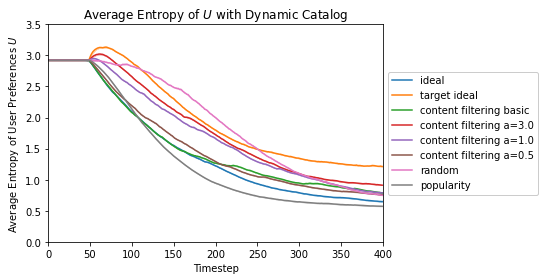

In [29]:
# results = merge_results(["udps_ouput_homog_fixed"])
# results = merge_results(["udps_ouput_homog_creators"])

model_keys = ["ideal", "target_ideal", "content_chaney", "content_chaney_j_3.0", "content_chaney_j_1.0", "content_chaney_j_0.5", "random", "popularity"]
    
plot_entropy(model_keys)